In [1]:
import random
import numpy as np
from enum import Enum 
import copy
from tqdm import tqdm_notebook, tqdm

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

In [3]:
GRID_SIZE=5
MAX_TIME = 20
random.seed(28)

## State

In [4]:
class State(object):
    def __init__(self, row, col, grid_size=GRID_SIZE):
        self.grid_size=grid_size
        self.row=row
        self.col=col
        self.pos = (row,col)
    
    def is_valid(self):
        if 0<=self.row<self.grid_size and 0<=self.col<self.grid_size:
            return True
        else:
            return False
    
    def is_corner(self):
        if self.row==0:
            if self.col==0 or self.col==self.grid_size-1:
                return True
        elif self.row==self.grid_size-1:
            if self.col==0 or self.col==self.grid_size-1:
                return True
        else:
            return False
    
    def is_edge(self):
        if self.row==0:
            if 0<self.col<self.grid_size-1:
                return True
        elif self.col==0:
            if 0<self.row<self.grid_size-1:
                return True
        elif self.row==self.grid_size-1:
            if 0<self.col<self.grid_size-1:
                return True
        elif self.col==self.grid_size-1:
            if 0<self.row<self.grid_size-1:
                return True
        else:
            return False
        
    def print(self):
        print("(",self.row, self.col,")")

## Action, Observation(Sound)

In [5]:
class Action(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
    
class Sound(Enum):
#     ROTOR = 0
    BUMP = 0
    
class Color(Enum):
    DARK = 0.1
    LIGHT = 0.9

## Observation Model

In [6]:
class Observation():
    def __init__(self):
        if GRID_SIZE==5:
            self.bump_prob = np.array([[Color.LIGHT, Color.LIGHT, Color.LIGHT, Color.DARK, Color.DARK],
                        [Color.LIGHT, Color.LIGHT, Color.DARK, Color.DARK, Color.DARK],
                        [Color.DARK, Color.DARK, Color.LIGHT, Color.LIGHT, Color.DARK],
                        [Color.DARK, Color.DARK, Color.DARK, Color.DARK, Color.DARK],
                        [Color.DARK, Color.LIGHT, Color.LIGHT, Color.LIGHT, Color.DARK]])
            self.bump_prob = np.array([[color.value for color in dist] for dist in self.bump_prob])
        else:
            self.bump_prob = np.random.random((GRID_SIZE, GRID_SIZE))
                
    
    def sample(self, state, obs):
        sound_prob = self.bump_prob[state.row][state.col]
        sound = np.random.choice([True,False], 1, p = [sound_prob, 1.0-sound_prob])[0]
        return sound  
    
    def get_bump_prob(self, state):
        sound_prob = self.rotor_prob[state.row][state.col]
        return sound_prob  
    
    def get_bump_emission_matrix(self):
        return self.bump_prob.flatten()
    
    def get_emission_matrix(self):
        bump_emission = self.get_bump_emission_matrix()
        return np.vstack((bump_emission, 1-bump_emission)).T

## Transition Model

In [7]:
def get_index(row, col, grid_size=GRID_SIZE):
    return ((grid_size*row) + col)

def get_state(index, grid_size=GRID_SIZE):
    return State(index//grid_size, index%grid_size)

## transition_matrix[A][B] --> from state A to state B
transition_matrix = np.zeros((GRID_SIZE**2, GRID_SIZE**2))

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        index = get_index(i, j, GRID_SIZE)
        state = State(i,j,GRID_SIZE)
        if state.is_corner():
            transition_matrix[index][index] = 0.5
            if i==0 and j==0:
                transition_matrix[index][get_index(i,j+1)] = 0.25
                transition_matrix[index][get_index(i+1,j)] = 0.25
            elif i==0 and j==GRID_SIZE-1:
                transition_matrix[index][get_index(i,j-1)] = 0.25
                transition_matrix[index][get_index(i+1,j)] = 0.25
            elif i==GRID_SIZE-1 and j==0:
                transition_matrix[index][get_index(i,j+1)] = 0.25
                transition_matrix[index][get_index(i-1,j)] = 0.25
            else:
                transition_matrix[index][get_index(i,j-1)] = 0.25
                transition_matrix[index][get_index(i-1,j)] = 0.25
        elif state.is_edge():
            transition_matrix[index][index] = 0.25
            if i==0:
                transition_matrix[index][get_index(i,j-1)] = 0.25
                transition_matrix[index][get_index(i,j+1)] = 0.25
                transition_matrix[index][get_index(i+1,j)] = 0.25
            elif i==GRID_SIZE-1:
                transition_matrix[index][get_index(i,j-1)] = 0.25
                transition_matrix[index][get_index(i,j+1)] = 0.25
                transition_matrix[index][get_index(i-1,j)] = 0.25
            elif j==0:
                transition_matrix[index][get_index(i-1,j)] = 0.25
                transition_matrix[index][get_index(i+1,j)] = 0.25
                transition_matrix[index][get_index(i,j+1)] = 0.25
            else:
                transition_matrix[index][get_index(i-1,j)] = 0.25
                transition_matrix[index][get_index(i+1,j)] = 0.25
                transition_matrix[index][get_index(i,j-1)] = 0.25
        else:
            transition_matrix[index][get_index(i+1,j)] = 0.25
            transition_matrix[index][get_index(i-1,j)] = 0.25
            transition_matrix[index][get_index(i,j+1)] = 0.25
            transition_matrix[index][get_index(i,j-1)] = 0.25

In [8]:
# print(transition_matrix)

## Initial Probability Distribution

In [9]:
init_dist_matrix = float(1/(GRID_SIZE*GRID_SIZE))*np.ones((GRID_SIZE, GRID_SIZE))
init_dist_matrix = init_dist_matrix.flatten()

## Environment

In [10]:
class Environment():
    def __init__(self, grid_size=GRID_SIZE):
        self.grid_size = grid_size
        self.obs = Observation()
        self.init_state = self.reset()
        
    def reset(self):
        return State(random.randrange(self.grid_size-1), random.randrange(self.grid_size-1))

    
    def get_next_state(self, state, action):
        next_state_dict = {Action.UP: State(state.row-1, state.col),
                           Action.DOWN: State(state.row+1, state.col),
                           Action.LEFT: State(state.row, state.col-1),
                           Action.RIGHT: State(state.row, state.col+1)}
        next_state = next_state_dict[action]
        if next_state.is_valid():
            return next_state
        else:
            return state
        
    def get_obs(self, state):
        bump = self.obs.sample(state, Sound.BUMP)
        if bump:
            return 0
        else:
            return 1
    
    def step(self, state):
        action = Action(random.randrange(4))
        next_state = self.get_next_state(state, action)
        observation = self.get_obs(next_state)
        return next_state, action, observation

In [11]:
def simulate(env, time_steps):
    states = []
    actions = []
    observations = []
    state = env.init_state
    states.append(state)
    observations.append(env.get_obs(state))
    
    for time in range(time_steps-1):
        state, action, obs = env.step(state)
        actions.append(action)
        states.append(state)
        observations.append(obs)
    return states, actions, observations
#     return states, observations

In [12]:
env = Environment()
states, actions, observations = simulate(env,MAX_TIME)

In [13]:
# for i in range(len(observations)-1):
#     states[i].print()
#     print(actions[i], observations[i])

## Filtering

In [14]:
Pi = init_dist_matrix
E = env.obs.get_emission_matrix() # emission matrix
T = transition_matrix # transition matrix
Pi.shape, E.shape, T.shape, len(observations)

((25,), (25, 2), (25, 25), 20)

In [15]:
def normalise(vector):
    norm_factor = vector.sum(axis=1)
    print(norm_factor)
    vector /= norm_factor[:, np.newaxis] 
    return vector

In [16]:
def forward(observations, Pi, E, T):
    alpha = np.zeros((len(observations), Pi.shape[0]))
    alpha[0,:] = Pi * E[:, observations[0]] 
    for t in range(1,len(observations)):
        for j in range(Pi.shape[0]):
            alpha[t, j] = np.dot(T[:,j], alpha[t-1, :]) * E[j, observations[t]]
    alpha = normalise(alpha)
    return alpha

In [17]:
alpha = forward(observations, Pi, E, T)

[4.20000000e-01 2.27600000e-01 8.38800000e-02 4.46800000e-02
 3.01294000e-02 2.10306875e-02 5.85024138e-03 2.42967537e-03
 1.31877886e-03 5.29443198e-04 2.90119561e-04 1.96335906e-04
 1.36984915e-04 9.84883096e-05 7.14675043e-05 1.91654468e-05
 1.13156231e-05 7.12108310e-06 5.06415163e-06 1.41596112e-06]


In [18]:
# for t in range(MAX_TIME):
#     est_state = get_state(np.argmax(alpha[t]))
#     est_state.print()
#     states[t].print()
#     print()

## Plots

### Colormaps

In [39]:
def plot(data, title):
    plt.imshow(data, cmap='bone', origin='upper')
    plt.title(title)
    plt.show()

### Log-likelihood over states

In [19]:
def plot_pred_ground(alpha, title):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8,8))
    fig.suptitle(title)
    t = 0
    for ax in axes.flat:
        ax.set_title('t='+str(t))
        im = ax.imshow(np.log(alpha[t].reshape(GRID_SIZE,GRID_SIZE)), cmap='bone', origin='upper')
        t += 1
    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.show()

In [21]:
%matplotlib

Using matplotlib backend: MacOSX


In [22]:
plot_pred_ground(alpha, "Log Likelihood - Single Modality(Bump) - Filtering")

In [20]:
# def plot_likelihood(alpha):
#     %matplotlib
#     im = None
#     for t in range(MAX_TIME):
#         data = np.log(alpha[t].reshape(GRID_SIZE,GRID_SIZE))
#         if not im:
#             im = plt.imshow(data, cmap='bone', origin='upper')
#             plt.colorbar(im)
#         else:
#             im.set_data(data)
#         plt.title("Log-likelood at time "+ str(t))
#         plt.draw()
#         plt.pause(0.2)
#     plt.close()

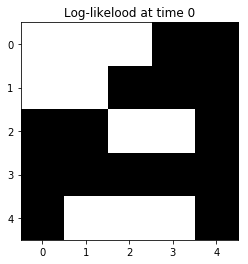

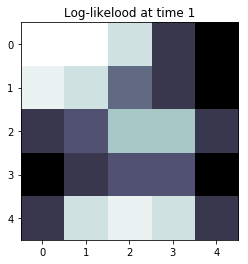

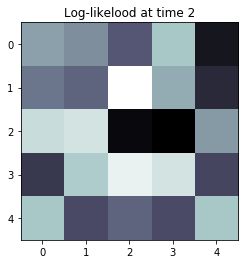

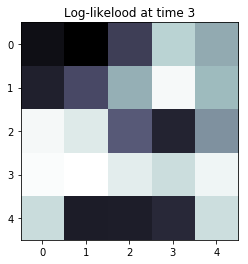

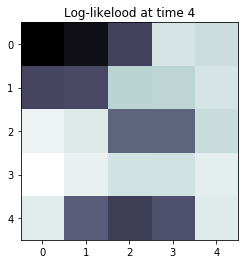

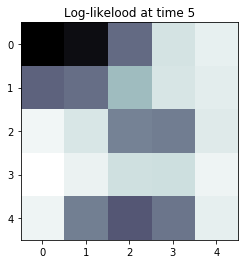

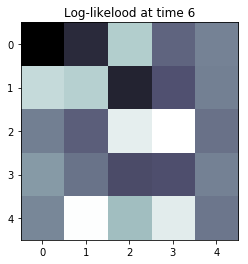

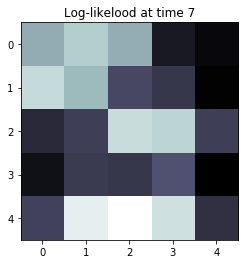

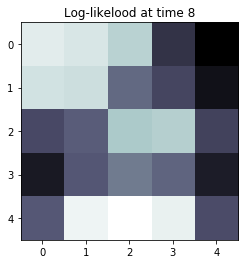

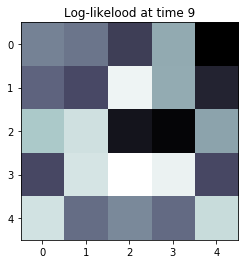

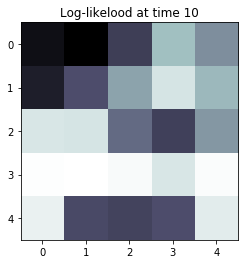

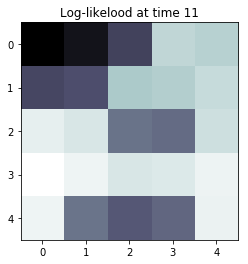

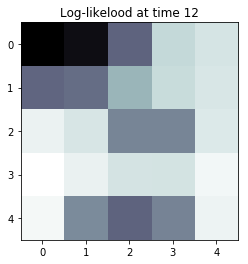

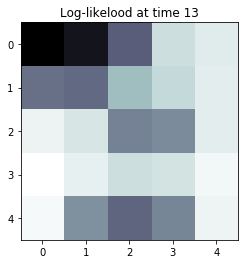

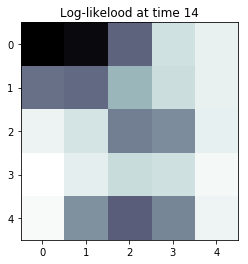

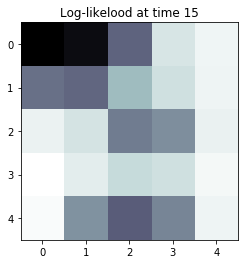

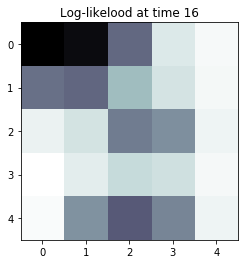

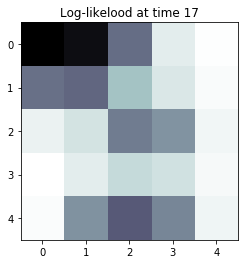

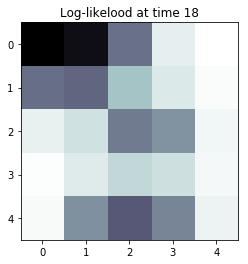

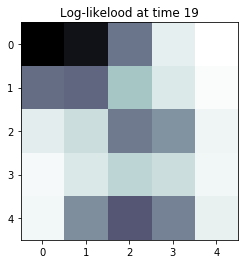

In [21]:
for t in range(MAX_TIME):
    data = np.log(alpha[t].reshape(GRID_SIZE,GRID_SIZE))
    plot(data,"Log-likelood at time "+ str(t))

In [23]:
# plot_likelihood(alpha)

## Most probable state

In [23]:
# def plot_ground_pred(data):
#     %matplotlib inline
#     for t in range(MAX_TIME):
#         index = np.argmax(alpha[t])
#         pred_state = get_state(index)
#         true_state = states[t]
#         data = np.zeros((GRID_SIZE, GRID_SIZE))
#         if pred_state.row==true_state.row and pred_state.col==true_state.col:
#             data[true_state.row, true_state.col] = -0.25
#         else:
#             data[pred_state.row, pred_state.col] = -1.0
#             data[true_state.row, true_state.col] = -0.75
#         plt.imshow(data, cmap='pink', origin='upper')
#         plt.title("Predicted v/s Ground Truth at time "+str(t))
#         plt.show()

In [33]:
def plot_ground_pred(data, title):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8,8))
    fig.suptitle(title)
    t = 0
    for ax in axes.flat:
        ax.set_title('t='+str(t))
        index = np.argmax(alpha[t])
        pred_state = get_state(index)
        true_state = states[t]
        data = np.zeros((GRID_SIZE, GRID_SIZE))
        if pred_state.row==true_state.row and pred_state.col==true_state.col:
            data[true_state.row, true_state.col] = -0.25
        else:
            data[pred_state.row, pred_state.col] = -0.75
            data[true_state.row, true_state.col] = -1.0
        im = ax.imshow(data, cmap='pink', origin='upper')
        t+=1
    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.show()

In [25]:
plot_ground_pred(alpha, "Predicted v/s Ground Truth - Single Modality")

## Prediction

In [26]:
prob_dist_last_state = alpha[-1]

In [27]:
def predict(prob_dist_last_state, T):
    prob_dist_next_state = np.matmul(T, prob_dist_last_state)
    return prob_dist_next_state

In [28]:
prob_dist_next_state = predict(prob_dist_last_state, T)

In [29]:
def predict_multiple(prob_dist_last_state, T, steps=5):
    likelihoods = []
    for t in range(steps):
        prob_dist_last_state = np.matmul(T, prob_dist_last_state)
        likelihoods.append(prob_dist_last_state)
    likelihoods = [np.log(l.reshape(GRID_SIZE, GRID_SIZE)) for l in likelihoods]
    return likelihoods

In [30]:
likelihoods = predict_multiple(prob_dist_last_state, T)

In [45]:
# for t,probs in enumerate(likelihoods):
#     plot(probs, "Time t+"+str(t+1))
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
fig.suptitle("Predictive Dist. over future location")
t = 0
for ax in axes.flat:
    ax.set_title('t='+str(t+10))
    im = ax.imshow(likelihoods[t], cmap='bone', origin='upper')
    t+=1
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4,4))
fig.suptitle("Predictive Dist. over next state given all evidence")
t = 0
for ax in axes.flat:
    ax.set_title('t='+str(10))
    im = ax.imshow(likelihoods[0], cmap='bone', origin='upper')
    t+=1
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()